In [1]:
import pandas as pd

folder = '/Users/stefan/Library/CloudStorage/OneDrive-Personal/Medicine/Montefiore/Heparin study/'
filename = 'heparin1.xlsx'
df = pd.read_excel(folder+filename)
# df.columns = ['size', 'number', 'concentration', 'volume', 'area']
df.head()

,Depth,Name,Statistic,#Cells
0,NaN,A1 Well_001.fcs,NaN,50000
1,>,A1 Well_001.fcs/Lymphocytes,87.7,43853
2,> >,A1 Well_001.fcs/Lymphocytes/Single Cells,96.5,42330
3,> > >,A1 Well_001.fcs/Lymphocytes/Single Cells/Singl...,99.7,42216
4,> > > >,A1 Well_001.fcs/Lymphocytes/Single Cells/Singl...,99.8,42131


In [3]:
df_mdsc = df.loc[df['Depth']=='> > > > > > > '].copy()
df_mdsc.head()

,Depth,Name,Statistic,#Cells
7,> > > > > > >,A1 Well_001.fcs/Lymphocytes/Single Cells/Singl...,0.0,0
8,> > > > > > >,A1 Well_001.fcs/Lymphocytes/Single Cells/Singl...,0.0,0
16,> > > > > > >,A2 Well_002.fcs/Lymphocytes/Single Cells/Singl...,0.0,0
17,> > > > > > >,A2 Well_002.fcs/Lymphocytes/Single Cells/Singl...,0.0,0
25,> > > > > > >,A3 Well_017.fcs/Lymphocytes/Single Cells/Singl...,0.0,0


In [4]:
df_mdsc[['well', 'population']] = df_mdsc['Name'].str.split('.fcs', expand=True)
df_mdsc = df_mdsc.drop(columns=['Name', 'Depth'])

In [5]:
df_mdsc['population'] = df_mdsc['population'].str.split('CD11B/', expand=True)[1]

In [6]:
well_removal = tuple(f'H{x}' for x in range(2,11,2))
well_removal

('H2', 'H4', 'H6', 'H8', 'H10')

In [7]:
df_mdsc = df_mdsc.loc[~df_mdsc['well'].str.startswith(well_removal)]

In [8]:
df_mdsc.head()

,Statistic,#Cells,well,population
7,0.0,0,A1 Well_001,gMDSC
8,0.0,0,A1 Well_001,mMDSC
16,0.0,0,A2 Well_002,gMDSC
17,0.0,0,A2 Well_002,mMDSC
25,0.0,0,A3 Well_017,gMDSC


In [9]:
def organ_lookup(cols: tuple[int]) -> tuple:
  output = []
  for i in cols:
      output += [char + str(i) for char in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')]
  return tuple(output)

spl_wells = organ_lookup((1,2))
bm_wells = organ_lookup((3,4))
ln_wells = organ_lookup((5,6))
thy_wells = organ_lookup((7,8))
brain_wells = organ_lookup((9,10))

In [10]:
df_mdsc['organ'] = ''
df_mdsc.loc[df_mdsc['well'].str.startswith(spl_wells), 'organ'] = 'spleen'
df_mdsc.loc[df_mdsc['well'].str.startswith(bm_wells), 'organ'] = 'bone marrow'
df_mdsc.loc[df_mdsc['well'].str.startswith(ln_wells), 'organ'] = 'lymph nodes'
df_mdsc.loc[df_mdsc['well'].str.startswith(thy_wells), 'organ'] = 'thymus'
df_mdsc.loc[df_mdsc['well'].str.startswith(brain_wells), 'organ'] = 'brain'

In [11]:
def well_lookup(letters: tuple[str]) -> tuple:
  output = []
  for char in letters:
    output += [char + str(i) for i in range(1, 11)]
  return tuple(output)

control_wells = well_lookup(('A', 'B'))
sham_sham_wells = well_lookup(('C', 'D'))
sham_EV_wells = well_lookup(('E', 'F'))
hep_sham_wells = well_lookup(('G'))
hep_EV_wells = well_lookup(('H'))

In [12]:
df_mdsc['group'] = ''
df_mdsc.loc[df_mdsc['well'].str.startswith(control_wells), 'group'] = 'control'
df_mdsc.loc[df_mdsc['well'].str.startswith(sham_sham_wells), 'group'] = 'sham+sham'
df_mdsc.loc[df_mdsc['well'].str.startswith(sham_EV_wells), 'group'] = 'sham+EV'
df_mdsc.loc[df_mdsc['well'].str.startswith(hep_sham_wells), 'group'] = 'hep+sham'
df_mdsc.loc[df_mdsc['well'].str.startswith(hep_EV_wells), 'group'] = 'hep+EV'

In [13]:
stats = df_mdsc.groupby(['group', 'organ', 'population']).describe()
stats['Statistic'].head()

count   mean       std  min  25%    50%  \
group   organ       population                                            
control bone marrow gMDSC         4.0  1.820  2.315297  0.0  0.0  1.225   
                    mMDSC         4.0  8.325  9.786853  0.0  0.0  7.200   
        brain       gMDSC         4.0  0.000  0.000000  0.0  0.0  0.000   
                    mMDSC         4.0  0.000  0.000000  0.0  0.0  0.000   
        lymph nodes gMDSC         4.0  1.270  1.736932  0.0  0.0  0.700   

                                   75%    max  
group   organ       population                 
control bone marrow gMDSC        3.045   4.83  
                    mMDSC       15.525  18.90  
        brain       gMDSC        0.000   0.00  
                    mMDSC        0.000   0.00  
        lymph nodes gMDSC        1.970   3.68

In [14]:
mean_stats = stats['Statistic'].loc[:, ['mean']]
mean_stats.head()

mean
group   organ       population       
control bone marrow gMDSC       1.820
                    mMDSC       8.325
        brain       gMDSC       0.000
                    mMDSC       0.000
        lymph nodes gMDSC       1.270

In [15]:
out = mean_stats.loc[[('sham+sham'), ('sham+EV'), ('hep+sham'), ('hep+EV')]]
out.head()

mean
group     organ       population        
sham+sham bone marrow gMDSC        2.685
                      mMDSC       11.175
          brain       gMDSC        0.195
                      mMDSC        0.000
          lymph nodes gMDSC        3.080

In [16]:
from scipy.stats import ttest_ind

out['p-value'] = ''
out['95% CI'] = ''

groups = (
  ('sham+sham', 'sham+EV'),
  ('hep+sham', 'hep+EV'),
)

organs = (
  'spleen',
  'bone marrow',
  'lymph nodes',
  'thymus',
  'brain',
)

populations = (
  'gMDSC',
  'mMDSC',
)

for subgroup in groups:
  for organ in organs:
    for pop in populations:
      res = ttest_ind(
        df_mdsc.loc[
          (df_mdsc['group'] == subgroup[0]) & 
          (df_mdsc['organ'] == organ) &
          (df_mdsc['population'] == pop)
          , 'Statistic'],
        df_mdsc.loc[
          (df_mdsc['group'] == subgroup[1]) & 
          (df_mdsc['organ'] == organ) &
          (df_mdsc['population'] == pop)
          , 'Statistic'],
      )
      ci = res.confidence_interval()
      for group in subgroup:
        out.at[(group, organ, pop), 'p-value'] = f"{res.pvalue:.2f}{'**' if res.pvalue < 0.05 else ''}"
        out.at[(group, organ, pop), '95% CI'] = f"[{ci.low:.2f}, {ci.high:.2f}]"

out

mean p-value             95% CI
group     organ       population                                      
sham+sham bone marrow gMDSC        2.685000    0.27      [-0.46, 1.36]
                      mMDSC       11.175000    0.59      [-3.56, 2.22]
          brain       gMDSC        0.195000    0.29      [-9.49, 3.43]
                      mMDSC        0.000000     nan       [0.00, 0.00]
          lymph nodes gMDSC        3.080000    0.95      [-3.70, 3.88]
                      mMDSC        4.882500    0.26      [-6.68, 2.18]
          spleen      gMDSC        1.001250    0.96      [-0.91, 0.96]
                      mMDSC        4.646250    0.78      [-7.00, 5.36]
          thymus      gMDSC        0.140000  0.02**       [0.01, 0.11]
                      mMDSC        1.292500    0.11      [-0.07, 0.52]
sham+EV   bone marrow gMDSC        2.235000    0.27      [-0.46, 1.36]
                      mMDSC       11.845000    0.59      [-3.56, 2.22]
          brain       gMDSC        3.227500    0.29      [-9.49, 3.43]
                      mMDSC        0.000000     nan       [0.00, 0.00]
          lymph nodes gMDSC        2.987500    0.95      [-3.70, 3.88]
                      mMDSC        7.132500    0.26      [-6.68, 2.18]
          spleen      gMDSC        0.977500    0.96      [-0.91, 0.96]
                      mMDSC        5.465000    0.78      [-7.00, 5.36]
          thymus      gMDSC        0.080000  0.02**       [0.01, 0.11]
                      mMDSC        1.067500    0.11      [-0.07, 0.52]
hep+sham  bone marrow gMDSC        2.625000    0.60    [-16.41, 14.62]
                      mMDSC       14.200000    0.58    [-86.33, 76.53]
          brain       gMDSC        0.000000     nan       [0.00, 0.00]
                      mMDSC        0.000000     nan       [0.00, 0.00]
          lymph nodes gMDSC        0.885000    0.54      [-8.83, 7.68]
                      mMDSC        5.320000    0.73  [-103.54, 111.26]
          spleen      gMDSC        1.605000    0.23      [-1.19, 3.82]
                      mMDSC        3.840000    0.37     [-5.21, 11.69]
          thymus      gMDSC        0.415000    0.93      [-4.26, 4.33]
                      mMDSC        0.940000    0.17      [-6.21, 3.47]
hep+EV    bone marrow gMDSC        3.520000    0.60    [-16.41, 14.62]
                      mMDSC       19.100000    0.58    [-86.33, 76.53]
          brain       gMDSC        0.000000     nan       [0.00, 0.00]
                      mMDSC        0.000000     nan       [0.00, 0.00]
          lymph nodes gMDSC        1.460000    0.54      [-8.83, 7.68]
                      mMDSC        1.460000    0.73  [-103.54, 111.26]
          spleen      gMDSC        0.290000    0.23      [-1.19, 3.82]
                      mMDSC        0.596667    0.37     [-5.21, 11.69]
          thymus      gMDSC        0.380000    0.93      [-4.26, 4.33]
                      mMDSC        2.310000    0.17      [-6.21, 3.47]

In [17]:
df_mdsc.head()

,Statistic,#Cells,well,population,organ,group
7,0.0,0,A1 Well_001,gMDSC,spleen,control
8,0.0,0,A1 Well_001,mMDSC,spleen,control
16,0.0,0,A2 Well_002,gMDSC,spleen,control
17,0.0,0,A2 Well_002,mMDSC,spleen,control
25,0.0,0,A3 Well_017,gMDSC,bone marrow,control


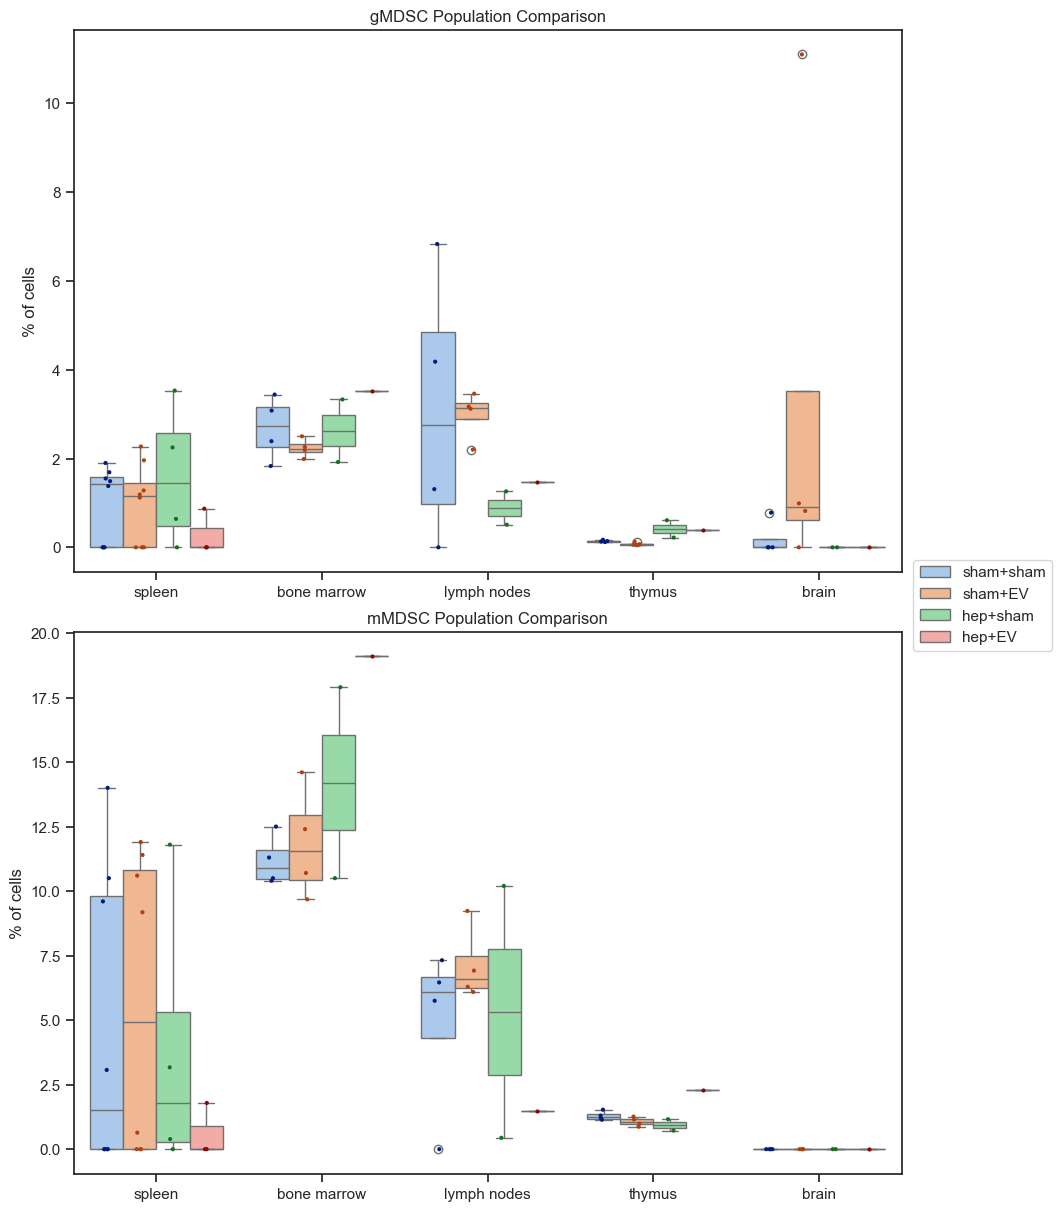

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="pastel")
# sns.set_theme(style="ticks", palette="Set1")

fig, axs = plt.subplots(2, 1, figsize=(9, 12), layout='constrained')

for i, pop in enumerate(('gMDSC', 'mMDSC')):
  data = df_mdsc.loc[
      (df_mdsc['group'] != 'control') & (df_mdsc['population'] == pop)
    ]
  g = sns.boxplot(
    data,
    x="organ", y="Statistic",
    hue="group",
    ax=axs[i],
  )

  sns.stripplot(
    data,
    x="organ", y="Statistic",
    hue="group", palette='dark',
    size=3, dodge=True,
    ax=axs[i],
    legend=False
  )
  g.set_title(f'{pop} Population Comparison')
  g.set_ylabel('% of cells')
  g.set_xlabel('')
  axs[i].legend().remove()

handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title=None)

plt.show()

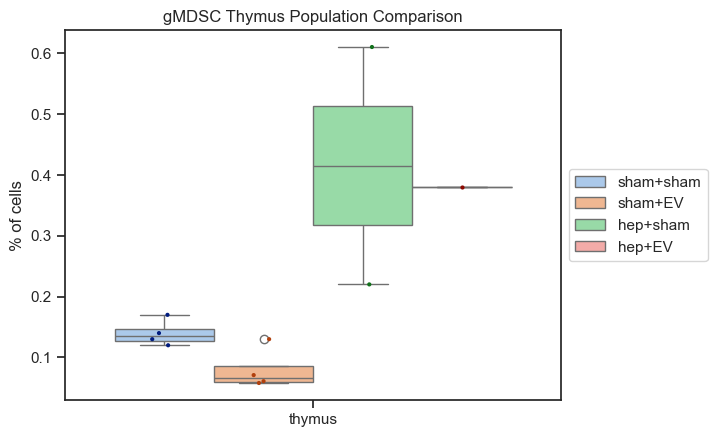

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="pastel")
# sns.set_theme(style="ticks", palette="Set1")


data = df_mdsc.loc[
    (df_mdsc['group'] != 'control') & (df_mdsc['population'] == 'gMDSC') & (df_mdsc['organ'] == 'thymus')
  ]
g = sns.boxplot(
  data,
  x="organ", y="Statistic",
  hue="group",
)

sns.stripplot(
  data,
  x="organ", y="Statistic",
  hue="group", palette='dark',
  size=3, dodge=True,
  legend=False
)
g.set_title('gMDSC Thymus Population Comparison')
g.set_ylabel('% of cells')
g.set_xlabel('')
g.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title=None)

plt.show()